# Laboratorium 6 - rekomendacje oparte na grafach wiedzy

## Przygotowanie

 * pobierz i wypakuj dataset: https://www.aicrowd.com/challenges/spotify-million-playlist-dataset-challenge
   * na potrzeby drugiej części laboratorium (czyli testowego treningu), na Teamsach macie dostępny podzbiór danych, `a_few_playlists_dataset` - nie wystarczy on jednak do wykonania trzeciej części (i tym samym do oddania laboratorium)
 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab6`
 * zainstaluj potrzebne biblioteki:
 `pip install numpy pandas pykeen tqdm seaborn`

## Część 1. - przygotowanie danych

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

from pykeen.models import TransE, TransH, TransR, RESCAL
from pykeen.pipeline import pipeline
from pykeen.predict import predict_target
from pykeen.triples import TriplesFactory
from pykeen.utils import resolve_device

/home/szymonbudziak/Studia_AGH/Semestr_7/Rekomendacyjne/Recommendation_systems_course_AGH/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check whether GPU is being used
resolve_device()

device(type='cuda')

In [3]:
# # konfiguracja datasetu Spotify
PATH = 'spotify_million_playlist_dataset/data'
SAMPLING_RATIO = 0.05
FILENAMES = random.sample([f'mpd.slice.{1000*i}-{1000*i+999}.json' for i in range(1000)], int(SAMPLING_RATIO*1000))
len(FILENAMES)

50

In [4]:
# jesli uzywasz datasetu pobranego z Teamsow, uzyj tej komorki zamiast powyzszej
# UWAGA - do oddania laboratorium konieczne jest uzycie oficjalnego datasetu Spotify
# PATH = 'a_few_playlists_dataset'
# SAMPLING_RATIO = 0.01
# with open(f'{PATH}/filenames.txt') as fn:
#     FILENAMES = fn.read().split('\n')

In [5]:
# funkcje do parsowania playlist
def get_id(uri):
    return uri.split(':')[-1]


def parse_playlist(playlist):
    name = playlist['name']
    tracks = [get_id(t['track_uri']) for t in playlist['tracks']]
    tracks_to_artists = {(get_id(t['track_uri']), get_id(t['artist_uri'])) for t in playlist['tracks']}
    tracks_to_albums = {(get_id(t['track_uri']), get_id(t['album_uri'])) for t in playlist['tracks']}
    albums_to_artists = {(get_id(t['album_uri']), get_id(t['artist_uri'])) for t in playlist['tracks']}
    return name, tracks, tracks_to_artists, tracks_to_albums, albums_to_artists

In [6]:
# parsing
playlists = []
tracks = set()
tracks_to_artists = set()
tracks_to_albums = set()
albums_to_artists = set()

for filename in tqdm(FILENAMES):
    with open(f'{PATH}/{filename}') as mpd_chunk:
        for playlist in json.loads(mpd_chunk.read())['playlists']:
            a, b, c, d, e = parse_playlist(playlist)
            playlists.append(b)
            tracks.update(set(b))
            tracks_to_artists.update(c)
            tracks_to_albums.update(d)
            albums_to_artists.update(e)

print(
    f'Got: {len(playlists):,} playlists; {len(tracks):,} tracks; {len({x[1] for x in tracks_to_albums}):,}albums; {len({x[1] for x in tracks_to_artists}):,} artists')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:23<00:00,  2.09it/s]


Got: 50,000 playlists; 462,545 tracks; 196,124albums; 80,353 artists


In [7]:
# w zbiorze testowym chcemy tylko te playlisty, ktorych wszystkie piosenki wystapia takze choc raz w zbiorze treningowym
tracks_counter = {}
for p in tqdm(playlists):
    for t in p:
        if t in tracks_counter:
            tracks_counter[t] += 1
        else:
            tracks_counter[t] = 1

playlists_with_only_non_unique_tracks = []
for i in tqdm(range(len((playlists)))):
    p = playlists[i]
    if all([tracks_counter[t] > 1 for t in p]):
        playlists_with_only_non_unique_tracks.append(i)

# zbior testowy to 1/10 wszystkich playlist - czyli 100k, jesli nie używamy samplingu
test_playlist_ids = random.sample(playlists_with_only_non_unique_tracks, int(SAMPLING_RATIO * 100_000))
# zbior treningowy to cala reszta playlist - jest ich duzo, wiec sprobujmy to zrobic wydajnie
test_ids_sorted = sorted(test_playlist_ids)
test_i = 0
train_playlist_ids = []
i = 0
while i < len(playlists):
    if test_i < len(test_ids_sorted) and test_ids_sorted[test_i] == i:
        test_i += 1
    else:
        train_playlist_ids.append(i)
    i += 1

train_playlists = [playlists[i] for i in train_playlist_ids]
test_playlists = [playlists[i] for i in test_playlist_ids]

print(f'train dataset: {len(train_playlists):,}; test dataset: {len(test_playlists):,}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:00<00:00, 53688.29it/s]

train dataset: 45,000; test dataset: 5,000


## Część 2. - budowa i ewaluacja modelu

### Relacje istniejące w naszym datasecie:
![poglądowy obrazek relacji w datasecie](relations.svg)

In [8]:
# budowanie zbioru relacji
# mozesz usunac czesc wpisow z listy `relations`
# relations = ['follows', 'authored_by', 'in_album', 'authored']
relations = ['follows']
triples = []

# relacje piosenka -> autor
if 'authored_by' in relations:
    for track, artist in tqdm(tracks_to_artists):
        triples.append((track, 'authored_by', artist))

# relacje piosenka -> artysta
if 'in_album' in relations:
    for track, album in tqdm(tracks_to_albums):
        triples.append((track, 'in_album', album))

# relacje artysta -> album
if 'authored' in relations:
    for album, artist in tqdm(albums_to_artists):
        triples.append((artist, 'authored', album))

# relacje piosenka -> piosenka
if 'follows' in relations:
    for playlist in tqdm(train_playlists):
        for i in range(len(playlist) - 1):
            triples.append((playlist[i], 'follows', playlist[i + 1]))

num_entities = len(triples)
num_relations = len(relations)

print(f'Got {num_relations} relations with total of {num_entities:,} entries')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 45000/45000 [00:00<00:00, 59102.51it/s]

Got 1 relations with total of 3,031,724 entries


In [16]:
# trening
tf = TriplesFactory.from_labeled_triples(np.array(triples))
# ta dysproporcja jest po to, by szybko uzyskac jakikolwiek wynik
#   - dla uzyskania sensownych wynikow warto zmienic split na np. standardowe 80-10-10
training, testing, validation = tf.split([.8, .1, .1])

pipeline_result = pipeline(
    training=training,
    testing=testing,
    validation=validation,
    model=TransE,
    # to najszybszy i najprostszy, ale i najgorszy model; pomysl o uzyciu TransH, TransR, RESCAL albo dowolnego innego
    epochs=5
    # to zdecydowanie za malo - 1 wystarczy do jakichkolwiek wynikow, 5 do dosc slabych, blizej 20 do sensownych
)

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1541809, 250245, 250245]
INFO:pykeen.pipeline.api:Using device: None
Training epochs on cuda:0: 100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [25:22<00:00, 304.51s/epoch, loss=0.165, prev_loss=0.2]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=16.
Evaluating on cuda:0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 250k/250k [1:06:54<00:00, 62.3triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 4023.02s seconds


<Axes: title={'center': 'Losses Plot'}, xlabel='Epoch', ylabel='marginranking Loss'>

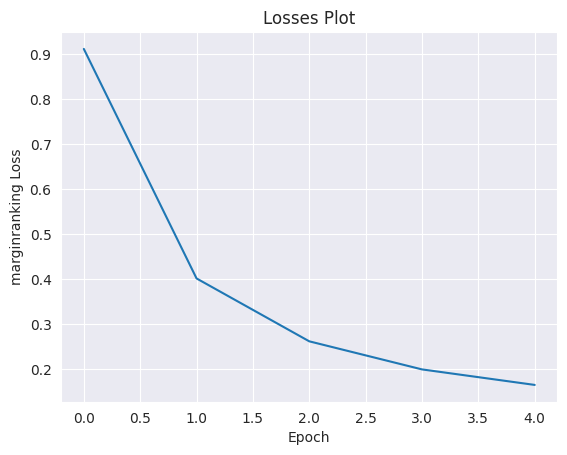

In [17]:
# zgrubne oszacowanie jakosci wytrenowanego modelu
pipeline_result.plot_losses()

In [11]:
# funkcja zwracajaca predykcje z modelu
def predict_next_tracks(model, track_id: str, k: int) -> list[str]:
    # Check if the track_id is in the entity-to-id mapping of the triples factory
    if track_id not in tf.entity_to_id:
        return []

    # Use the predict_target function from PyKEEN to get predictions
    # The function takes the model, head entity (track_id), and relation ('follows') as arguments
    predictions = predict_target(model=model, head=track_id, relation='follows', triples_factory=tf)

    # Get the dataframe with the predictions
    df = predictions.df

    # Sort the DataFrame by the 'score' column in descending order, take the top 'k' rows,
    # select the 'tail_label' column, and convert it to a list
    return df.sort_values(by='score', ascending=False).head(k).loc[:, 'tail_label'].tolist()

In [12]:
# metryki do porownania rekomenderow - precision@k i recall@k
def precision(prediction: list[str], actual_tracks: list[str]) -> float:
    # Calculate precision
    if len(prediction) == 0:
        return 0.0
    else:
        # Calculate the intersection between the predicted and actual tracks
        intersection = set(prediction) & set(actual_tracks)
        return len(intersection) / len(prediction)


def recall(prediction: list[str], actual_tracks: list[str]) -> float:
    # Calculate recall
    if len(actual_tracks) == 0:
        return 0.0
    else:
        # Calculate the intersection between the predicted and actual tracks
        intersection = set(prediction) & set(actual_tracks)
        return len(intersection) / len(actual_tracks)

Evaluating playlists: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4701/4701 [26:06<00:00,  3.00it/s]


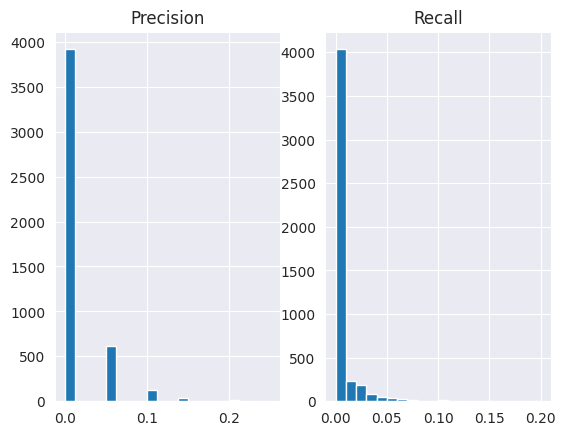

In [13]:
# ocena wynikow

# odsiewamy playlisty zbyt krotkie, by dac sensowne wyniki
long_enough_test_playlists = [p for p in test_playlists if len(p) >= 10]
# z kazdej playlisty, elementy od 0 do `cutoff_idx` wlacznie sa dane, na ich podstawie robimy predykcje
# elementy od cutoff_idx+1 do konca powinnismy umiec przewidziec
cutoff_idx = 4
# ile elementow ma przewidziec nasz model
k = 20
precisions: list[float] = []
recalls: list[float] = []

model = pipeline_result.model

for playlist in tqdm(long_enough_test_playlists, desc='Evaluating playlists'):
    # Use your predict_next_tracks function to get predictions for the playlist
    predicted_tracks = predict_next_tracks(model, playlist[cutoff_idx], k)

    # Ground truth tracks from cutoff_idx+1 to the end
    actual_tracks = playlist[cutoff_idx + 1:]

    # Calculate precision and recall for the playlist
    playlist_precision = precision(predicted_tracks, actual_tracks)
    playlist_recall = recall(predicted_tracks, actual_tracks)

    precisions.append(playlist_precision)
    recalls.append(playlist_recall)

# histogram z wynikami
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(precisions, bins=20)
ax1.set_title('Precision')
ax2.hist(recalls, bins=20)
ax2.set_title('Recall')
plt.show()

## Część 3. - porównanie różnych metod rekomendacji

W części 2. zbudowaliśmy zbiór trójek relacji, wytrenowaliśmy jeden model, zaimplementowaliśmy (prostą) metodę generującą rekomendacje na podstawie predykcji modelu i w końcu zaimplementowaliśmy dwie metryki do porównania jakości tych rekomendacji.

W części 3. Twoim zadaniem jest przetestować trzy różne podejścia do jednego z kroków:
1. Porównaj trzy różne modele spośród dostępnych w bibliotece PyKeen: https://pykeen.readthedocs.io/en/stable/reference/models.html#classes
   * jeden model translacyjny (np. TransE, TransH, TransR)
   * jeden model faktoryzacyjny (np. RESCAL)
   * jeden dowolny model niewybrany w poprzednich punktach
2. Porównaj trzy metody budowania grafu wiedzy:
   * graf zawierający relacje wszystkich czterech typów
   * graf zawierający tylko relacje typu `follows` (czyli między kolejnymi utworami w playliście)
   * graf zawierający relacje wybranych przez Ciebie dwóch lub trzech typów (czyli krok pośredni między powyższymi punktami)
3. Porównaj trzy metody generowania rekomendacji na podstawie elementów zwróconych przez `predict_target()` (ta metoda zwraca m. in. score'y każdego z proponowanych elementów, co może okazać się pomocne):
   * metoda opierająca się tylko na predykcji dla ostatniego znanego elementu w playliście
   * dwie wymyślone przez Ciebie, bardziej zaawansowane metody
  
Niezależnie od tego, który z trzech powyższych scenariuszy wybierzesz - porównaj trzy wybrane przez Ciebie metody na podstawie histogramów metryk `precision@k` i `recall@k`.

### 1) Compare different models from PyKeen library

INFO:pykeen.pipeline.api:Using device: None
Training epochs on cuda:0: 100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [19:34<00:00, 391.51s/epoch, loss=0.343, prev_loss=0.419]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=8.
Evaluating on cuda:0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 250k/250k [2:44:08<00:00, 25.4triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 9856.84s seconds
Evaluating playlists for model: TransR: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4701/4701 [26:47<00:00,  2.92it/s]


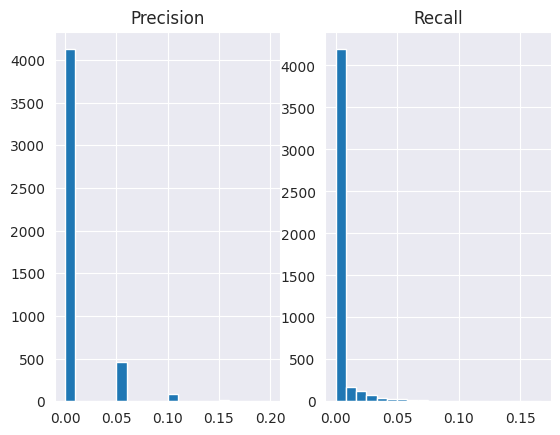

INFO:pykeen.pipeline.api:Using device: None


Model: TransR
Average precision: 0.007551584769198043
Average recalls: 0.00343517433865349




Training epochs on cuda:0: 100%|██████████████████████████████████████████████████████████████████████████████████| 3/3 [13:04<00:00, 261.42s/epoch, loss=6.26, prev_loss=9.94]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=32.
Evaluating on cuda:0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250k/250k [37:35<00:00, 111triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 2264.01s seconds
Evaluating playlists for model: RESCAL: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4701/4701 [25:45<00:00,  3.04it/s]


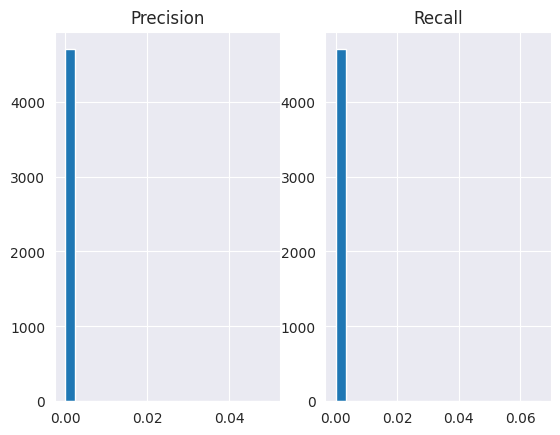

INFO:pykeen.pipeline.api:Using device: None


Model: RESCAL
Average precision: 2.1272069772388854e-05
Average recalls: 2.0437870957785366e-05




Training epochs on cuda:0: 100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [21:05<00:00, 421.89s/epoch, loss=0.448, prev_loss=0.572]
INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...
INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=8.
Evaluating on cuda:0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 250k/250k [2:01:20<00:00, 34.4triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 7288.62s seconds
Evaluating playlists for model: TransH: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4701/4701 [25:46<00:00,  3.04it/s]


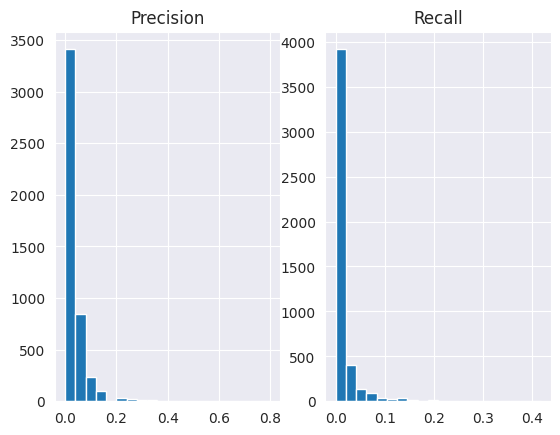

Model: TransH
Average precision: 0.023941714528823654
Average recalls: 0.011462181021838509




In [14]:
translational_model = TransR
factorization_model = RESCAL
other_model = TransH

models_types = [translational_model, factorization_model, other_model]
model_names = ['TransR', 'RESCAL', 'TransH']

cutoff_idx = 4
k = 20

for model_type, model_name in zip(models_types, model_names):
    precisions = []
    recalls = []

    # Train the model using the specified model
    pipeline_result = pipeline(
        training=training,
        testing=testing,
        validation=validation,
        model=model_type,
        epochs=3
    )

    model = pipeline_result.model

    for playlist in tqdm(long_enough_test_playlists, desc=f'Evaluating playlists for model: {model_name}'):
        # Use your predict_next_tracks function to get predictions for the playlist
        predicted_tracks = predict_next_tracks(model, playlist[cutoff_idx], k)

        # Ground truth tracks from cutoff_idx+1 to the end
        actual_tracks = playlist[cutoff_idx + 1:]

        # Calculate precision and recall for the playlist
        playlist_precision = precision(predicted_tracks, actual_tracks)
        playlist_recall = recall(predicted_tracks, actual_tracks)

        precisions.append(playlist_precision)
        recalls.append(playlist_recall)

    # histogram z wynikami
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.hist(precisions, bins=20)
    ax1.set_title('Precision')
    ax2.hist(recalls, bins=20)
    ax2.set_title('Recall')
    plt.show()

    print(f'Model: {model_name}\nAverage precision: {np.mean(precisions)}\nAverage recalls: {np.mean(recalls)}\n\n')